# Eurostat European Big Data Hackathon 2025

<img src="img/EU-Big-Data-Hackathon-2025_horiz_0.jpg" width="500"/>


Eurostat is organizing the fifth round of the European Big Data Hackathon from 6 to 11 March 2025 (including the presentation by the winners at the NTTS) in Brussels. 

The purpose of the 2025 hackathon is to foster expertise in integrating Earth Observation data with official statistics for producing innovative ideas for statistical products and tools relevant for the EU policies. 


The European Big Data Hackathon takes place every two years and gathers teams from all over Europe to compete for the best solution to a statistical challenge. The teams develop innovative approaches, applications and data products combining official statistics and big data that can help to answer pressing EU policy and/or statistical questions.

_Source: https://cros.ec.europa.eu/2025EuropeanBigDataHackathon_

*This notebook provides information on how to access datasets of interest to hackathon participants*

The Copernicus Data Space Ecosystem offers immediate access to large amounts of open and free Earth observation data from the Copernicus Sentinel satellites, including both new and historical Sentinel images, as well as Copernicus Contributing Missions. As the effects of climate change intensifies, the use of earth observation data will become ever more important to monitor wildfires in the southern Europe including Portugal. These two notebooks will show how you can utilise Copernicus data to do just this.

The Copernicus Data Space Ecosystem supports users in accessing, viewing, using, downloading, and analyzing data. The Copernicus Data Space Ecosystem is set up to further improve access and exploitation of the EU’s Copernicus satellites data. The service aims to support users in building various applications needed to provide accurate, timely and objective information which are crucial to create a more sustainable future.

The Copernicus Data Space Ecosystem offers multiple Application Programming Interfaces (APIs) ranging from catalogue, product download, visualization over processing web services such as STAC, openEO and Sentinel Hub APIs. This Jupyter notebook focuses on the Sentinel Hub APIs. The Sentinel Hub API is a RESTful API interface that provides access to various satellite imagery archives. It allows you to access raw satellite data, rendered images, statistical analysis, and other features.



## Hackathon auxiliary datasets

The auxiliary statistical datasets will be made available for all participants via API and object storage. This Notebook covers access to the datasets in raster format through the Copernicus Data Space Ecosystem APIs (with a focus on the Sentinel Hub APIs).

### ESA WorldCover

The ESA WorldCover dataset is currently only available through openEO: see this [link](https://dataspace.copernicus.eu/news/2024-5-15-access-global-landcover-using-openeo) for more information.


### Population grid   

The population grid is a geographical dataset showcasing 13 different population-related variables (e.g. total population, its breakdown by sex) produced on the 1 km2 grid during the Census 2021 by the EU Member States. The projection is the ETRS89-LAEA grid.  

For more information: https://ec.europa.eu/eurostat/web/gisco/geodata/population-distribution/geostat 

#### Collection information

*Collection ID*: `36caf873-32ca-44be-ba3e-e6c1b759211c`

*Date / Time of dataset*: `01 January 2021, 00:00 (UTC)`

*Bands*:

| Band                  | Description                                               |
|-----------------------|-----------------------------------------------------------|
| OBS_VALUE_T           | Total population                                          |
| OBS_VALUE_M           | Male Population                                           |
| OBS_VALUE_F           | Female Population                                         |
| OBS_VALUE_Y_LT15      | Age Under 15 years                                        |
| OBS_VALUE_Y_1564      | Age 15 to 64 years                                        |
| OBS_VALUE_Y_GE65      | Age 65 years and over                                     |
| OBS_VALUE_EMP         | Employed persons                                          |
| OBS_VALUE_NAT         | Place of birth in reporting country                       |
| OBS_VALUE_EU_OTH      | Place of birth in other EU Member State                   |
| OBS_VALUE_OTH         | Place of birth elsewhere                                  |
| OBS_VALUE_SAME        | Place of usual residence one year prior to the census unchanged |
| OBS_VALUE_CHG_IN      | Place of usual residence one year prior to the census: move within reporting country |
| OBS_VALUE_CHG_OUT     | Place of usual residence one year prior to the census: move from outside of the reporting country |

## Example data access with Process API using Python SDK

In [1]:
from sentinelhub import (
    SHConfig,
    BBox,
    CRS,
    bbox_to_dimensions,
    SentinelHubRequest,
    DataCollection,
    MimeType,
)
import matplotlib.pyplot as plt

## Authentication

You can obtain the credentials for the Sentinel Hub services (`client_id` & `client_secret`) in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the user settings, you can create a new OAuth client to generate these credentials. You can find more detailed instructions on the corresponding [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions for configuring your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions, you can create a profile specifically tailored to use the package to access the Copernicus Data Space Ecosystem data collections. This is useful because changes to the Config class in your notebook are usually only temporary. If you save the configuration in your profile, you do not have to generate new credentials or overwrite/change the default profile every time you start or write a new Jupyter notebook.

If you are using the Sentinel Hub Python package for the Copernicus Data Space Ecosystem for the first time, you should create a profile specifically for the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [2]:
config = SHConfig()
config.sh_client_id = ''
config.sh_client_secret = ''
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

### Setting area of interest

See https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request_cdse.html#Setting-area-of-interest


In [3]:
# Area over North Italy in EPSG:3035
coords = [4232522.252975, 2465876.263074, 4289909.994971, 2506533.655502]

In [4]:
resolution = 1000
bbox = BBox(bbox=coords, crs="EPSG:3035")
bbox_size = bbox_to_dimensions(bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {bbox_size} pixels")

Image shape at 1000 m resolution: (57, 41) pixels


### Setting the Evalscript

In the following cell, we will set an [Evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html) to fetch raw data from the Population Grid dataset. As described further up in this Notebook, we will fetch 2 bands: 

- Place of birth in reporting country: `OBS_VALUE_NAT`
- Place of birth in other EU Member State: `OBS_VALUE_EU_OTH`

and write them to 2 different files.

In [5]:
evalscript_2bands = """
    //VERSION=3

function setup() {
  // This specifies inputs and outputs of the script.
  return {
    input: [
      {
        bands: ["OBS_VALUE_NAT", "OBS_VALUE_EU_OTH"],
      },
    ],
    output: [
      {
        id: "nat",
        bands: 1,
        sampleType: SampleType.FLOAT32,
      },
      { id: "eu_oth", bands: 1, sampleType: SampleType.FLOAT32 },
    ],
  };
}

function evaluatePixel(sample) {
  // This function returns the output value for each pixel.
  return {
    nat: [sample.OBS_VALUE_NAT],
    eu_oth: [sample.OBS_VALUE_EU_OTH],
  };
}

"""

### Setting the payload

In the following cell, we will build a request, following the [example](https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request_cdse.html#Example-1:-True-color-(PNG)-on-a-specific-date) in the documentation, but modifying it to access the Population Grid collection based on it's ID.

In [6]:
request = SentinelHubRequest(
    evalscript=evalscript_2bands,
    input_data=[
        SentinelHubRequest.input_data(
            # Here we use the collection defined in the description further up
            DataCollection.define_byoc("36caf873-32ca-44be-ba3e-e6c1b759211c"),
            # The time interval for the data is a fixed date (see the description further up)
            time_interval=("2021-01-01", "2021-01-01"),
        )
    ],
    responses=[
        SentinelHubRequest.output_response("nat", MimeType.TIFF),
        SentinelHubRequest.output_response("eu_oth", MimeType.TIFF),
    ],
    bbox=bbox,
    size=bbox_size,
    data_folder="results",
    config=config,
)

### Run the request and download the data locally

In [7]:
bands = request.get_data(save_data=True)

### Plot the results

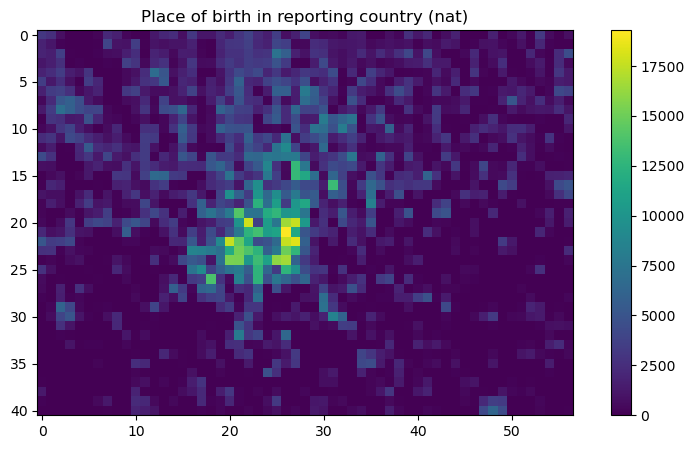

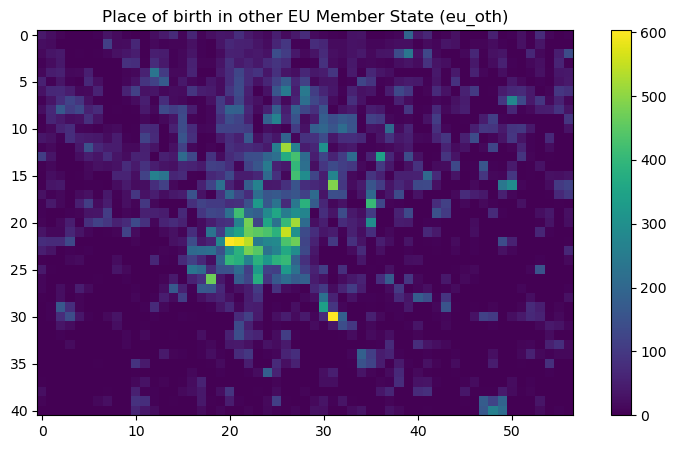

In [8]:
# Extract the bands from the list
nat_band = bands[0]['nat.tif']
eu_oth_band = bands[0]['eu_oth.tif']

# Plot the 'nat' band
plt.figure(figsize=(10, 5))
plt.title('Place of birth in reporting country (nat)')
plt.imshow(nat_band, cmap='viridis')
plt.colorbar()
plt.show()

# Plot the 'eu_oth' band
plt.figure(figsize=(10, 5))
plt.title('Place of birth in other EU Member State (eu_oth)')
plt.imshow(eu_oth_band, cmap='viridis')
plt.colorbar()
plt.show()